# Алгоритм классификации требований текстов нормативных документов

In [1]:
import pandas as pd
import numpy as np

import re
import string
import nltk
from nltk.stem import WordNetLemmatizer
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.model_selection import train_test_split
from sklearn import preprocessing

import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import ComplementNB
from sklearn.naive_bayes import BernoulliNB
from xgboost import XGBClassifier

In [2]:
def normalization_v2(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.replace("‘", '‘').replace("’", '’').replace("'", " '")
    text = re.sub(r"['‘’]\w+\b", '', text)
    text = re.sub(r"['‘’]", '', text)
    text = re.sub(r'[“”"•]', '', text)
    
    x = re.findall(r"\d", "ldcnk skjnk njdjm")    #numbers in text
    
    text = re.sub(r'(\d\.\s)+', '', text)
    text = re.sub(r'(\d\.)+', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r"–", '', text)
#    text = re.sub(r"\s\w\s", '', text)
    if len(x) > 0:                              #marker that there were numbers in text
        text += '11111'
    text = text.strip()
    lemma = WordNetLemmatizer()
    tokens = nltk.word_tokenize(text)
    tokens = [lemma.lemmatize(word, pos = "v") for word in tokens]
    tokens = [lemma.lemmatize(word, pos = "n") for word in tokens]
    text = ""
    for tok in tokens:
        text += tok
        text += " "
    return text

In [3]:
df_1 = pd.read_csv('Train_Standards-Table.csv', sep=';', header = None)
df_1.columns=['Source document ID', 'CI_ID', 'CI_Version', 'CI_Description EN', 'CI_Description RU', 'DocumentObjectClass', 'I&C scope', 'Technical/Process']
df_1.head()

,Source document ID,CI_ID,CI_Version,CI_Description EN,CI_Description RU,DocumentObjectClass,I&C scope,Technical/Process
0,IAEA-GSR2,IAEA-GSR2-1,6-2016,Requirement 1: Achieving the fundamental safet...,NaN,Requirement,Yes,Process
1,IAEA-GSR2,IAEA-GSR2-1-2.2,6-2016,"2.2. The senior management of organizations, i...",NaN,Requirement,Yes,Process
2,IAEA-GSR2,IAEA-GSR2-2-3.1,6-2016,3.1. The senior management of the organization...,NaN,Requirement,Yes,Process
3,IAEA-GSR2,IAEA-GSR2-2-3.3,6-2016,3.3. Managers at all levels in the organizatio...,NaN,Requirement,Yes,Process
4,IAEA-GSR2,IAEA-GSR2-3-4.1,6-2016,4.1. Senior management shall retain accountabi...,NaN,Requirement,Yes,Process


In [4]:
df_2 = pd.read_csv('Test_Standards-Table.csv', sep=';', header = None)
df_2.columns=['Source document ID', 'CI_ID', 'CI_Version', 'CI_Description EN', 'CI_Description RU', 'DocumentObjectClass', 'I&C scope', 'Technical/Process']
df_2.head()

,Source document ID,CI_ID,CI_Version,CI_Description EN,CI_Description RU,DocumentObjectClass,I&C scope,Technical/Process
0,IAEA-GSR2,IAEA-GSR2-1-2.1,6-2016,2.1. The registrant or licensee shall ensure t...,NaN,Requirement,Yes,Process
1,IAEA-GSR2,IAEA-GSR2-2,6-2016,Requirement 2: Demonstration of leadership for...,NaN,Requirement,Yes,Process
2,IAEA-GSR2,IAEA-GSR2-2-3.2,6-2016,3.2. Managers at all levels in the organizatio...,NaN,Requirement,Yes,Process
3,IAEA-GSR2,IAEA-GSR2-3,6-2016,Requirement 3: Responsibility of senior manage...,NaN,Requirement,Yes,Process
4,IAEA-GSR2,IAEA-GSR2-3-4.2,6-2016,4.2. Senior management shall be responsible fo...,NaN,Requirement,Yes,Process


In [5]:
df1 = pd.DataFrame(columns=['text', 'class'])
df2 = pd.DataFrame(columns=['text', 'class'])
df1['text'] = df_1['CI_Description EN']
df1['class'] = df_1['DocumentObjectClass']
df2['text'] = df_2['CI_Description EN']
df2['class'] = df_2['DocumentObjectClass']
df1['data'] = df1['text'].str.lower()
df2['data'] = df2['text'].str.lower()
df1['data'] = df1['data'].apply(lambda x: normalization_v2(x))
df2['data'] = df2['data'].apply(lambda x: normalization_v2(x))

In [6]:
count_vect = CountVectorizer()
X_counts = count_vect.fit_transform(df1['data'])

tfidf_transformer = TfidfTransformer()
train_tfidf_transformer = tfidf_transformer.fit(X_counts)


In [7]:
X_train = train_tfidf_transformer.transform(X_counts)

le = preprocessing.LabelEncoder()
le.fit(df1['class'])
y_train = le.transform(df1['class'])

#X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, train_size=0.6)

In [8]:
X_test = train_tfidf_transformer.transform(count_vect.transform(df2['data']))
le = preprocessing.LabelEncoder()
le.fit(df2['class'])
y_test = le.transform(df2['class'])

In [9]:
print (X_train.shape)
print (X_test.shape)

(1880, 2580)
(1880, 2580)


In [10]:
print (len(y_train))
print (len(y_test))

1880
1880


## Modal verbs: may, might, can, could, must, shall, should

In [11]:
TP = 0
FP = 0
TN = 0
FN = 0

for i in range(0, len(df2)):
    may = df2['data'][i].find('may')
    might = df2['data'][i].find('might')
    can = df2['data'][i].find('can')
    could = df2['data'][i].find('could')
    must = df2['data'][i].find('must')
    shall = df2['data'][i].find('shall')
    should = df2['data'][i].find('should')
    
    if ((may != -1 or might != -1 or can != -1 or could != -1 or must != -1 or shall != -1 or should != -1)
        and df2['class'][i] == 'Requirement'): TP += 1
    elif ((may != -1 or might != -1 or can != -1 or could != -1 or must != -1 or shall != -1 or should != -1)
        and df2['class'][i] != 'Requirement'): FP += 1
    elif ((may == -1 and might == -1 and can == -1 and could == -1 and must == -1 and shall == -1 and should == -1)
        and df2['class'][i] == 'Requirement'): FN += 1
    elif ((may == -1 and might == -1 and can == -1 and could == -1 and must == -1 and shall == -1 and should == -1)
        and df2['class'][i] != 'Requirement'): TN += 1
        
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1 = 2 * TP / (2 * TP + FP + FN)

print ('precision =', precision)
print ('recall =', recall)
print ('f1 =', f1)

precision = 0.9308790383170549
recall = 0.8568464730290456
f1 = 0.8923298523586605


In [12]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

length = len(df2)

y_test_roc = np.zeros(length)
y_pred_roc = np.zeros(length)

for i in range (length):
     if (df2['class'][i] == 'Requirement'): y_test_roc[i] = 1
        
for i in range (length):
    may = df2['data'][i].find('may')
    might = df2['data'][i].find('might')
    can = df2['data'][i].find('can')
    could = df2['data'][i].find('could')
    must = df2['data'][i].find('must')
    shall = df2['data'][i].find('shall')
    should = df2['data'][i].find('should')
    if (may != -1 or might != -1 or can != -1 or could != -1 or must != -1 or shall != -1 or should != -1):
        y_pred_roc[i] = 1
        
fpr, tpr, thresholds = metrics.roc_curve(y_test_roc, y_pred_roc)

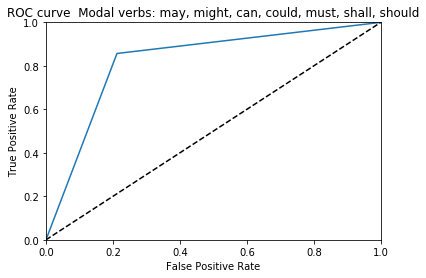

In [13]:
fig, ax = plt.subplots()

ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve  Modal verbs: may, might, can, could, must, shall, should')
plt.show()

fig.savefig('ROC curve Modal verbs: may, might, can, could, must, shall, should')

In [14]:
print ("AUC ROC", metrics.roc_auc_score(y_test_roc, y_pred_roc))

AUC ROC 0.8224324531043847


## BernoulliNB

In [15]:
from sklearn.naive_bayes import BernoulliNB
clf = BernoulliNB()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(metrics.classification_report(y_test, y_pred, target_names=le.classes_[np.unique(y_test)]))#le.classes_[np.unique(predicted)]

beta = 0.5
print ("beta =", beta, 'fbeta_score =', metrics.fbeta_score(y_test, y_pred, beta = 0.5, average='weighted'))

              precision    recall  f1-score   support

      Figure       0.00      0.00      0.00         5
     Heading       0.76      0.94      0.84       253
 Information       0.51      0.17      0.26       169
 Requirement       0.90      0.94      0.92      1446
       Title       0.00      0.00      0.00         7

    accuracy                           0.86      1880
   macro avg       0.43      0.41      0.40      1880
weighted avg       0.84      0.86      0.84      1880

beta = 0.5 fbeta_score = 0.8368288297119147


/Users/marychikunova/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [16]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score

random_search = {'alpha': list(np.linspace(0.0, 1.0, 11, dtype = float)) + [None],
               'binarize': list(np.linspace(0.0, 1.0, 11, dtype = float)) + [None],
               'fit_prior': [True, False]}

clf = BernoulliNB()
model = RandomizedSearchCV(estimator = clf, param_distributions = random_search, n_iter = 80, 
                               cv = 4, verbose= 5, random_state= 101, n_jobs = -1)
model.fit(X_train,y_train)

Fitting 4 folds for each of 80 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:    1.6s finished


RandomizedSearchCV(cv=4, error_score=nan,
                   estimator=BernoulliNB(alpha=1.0, binarize=0.0,
                                         class_prior=None, fit_prior=True),
                   iid='deprecated', n_iter=80, n_jobs=-1,
                   param_distributions={'alpha': [0.0, 0.1, 0.2,
                                                  0.30000000000000004, 0.4, 0.5,
                                                  0.6000000000000001,
                                                  0.7000000000000001, 0.8, 0.9,
                                                  1.0, None],
                                        'binarize': [0.0, 0.1, 0.2,
                                                     0.30000000000000004, 0.4,
                                                     0.5, 0.6000000000000001,
                                                     0.7000000000000001, 0.8,
                                                     0.9, 1.0, None],
                          

In [17]:
predictionforest = model.best_estimator_.predict(X_test)
print(metrics.confusion_matrix(y_test,predictionforest), '\n')
print(metrics.classification_report(y_test, predictionforest, target_names=le.classes_[np.unique(y_test)]))
acc3 = metrics.accuracy_score(y_test,predictionforest)

[[   0    2    0    3    0]
 [   0  238    1   14    0]
 [   0    7   29  133    0]
 [   0   61   27 1357    1]
 [   0    6    0    1    0]] 

              precision    recall  f1-score   support

      Figure       0.00      0.00      0.00         5
     Heading       0.76      0.94      0.84       253
 Information       0.51      0.17      0.26       169
 Requirement       0.90      0.94      0.92      1446
       Title       0.00      0.00      0.00         7

    accuracy                           0.86      1880
   macro avg       0.43      0.41      0.40      1880
weighted avg       0.84      0.86      0.84      1880



/Users/marychikunova/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [18]:
length = len(y_test)

y_test_roc = np.zeros(length)
y_test_roc

array([0., 0., 0., ..., 0., 0., 0.])

In [19]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

length = len(y_test)

y_test_roc = np.zeros(length)
y_pred_roc = np.zeros(length)

for i in range (length):
    if(y_test[i] == 3): y_test_roc[i] = 1
        
for i in range (length):
    if(y_pred[i] == 3): y_pred_roc[i] = 1
        
fpr, tpr, thresholds = metrics.roc_curve(y_test_roc, y_pred_roc)

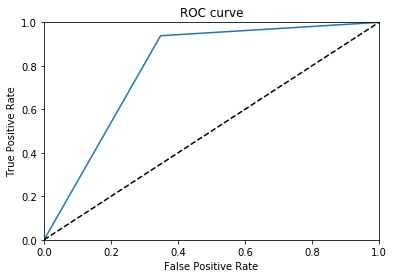

In [20]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()

In [21]:
print ("AUC ROC", metrics.roc_auc_score(y_test_roc, y_pred_roc))

AUC ROC 0.7952623158753529


## ComplementNB

In [22]:
from sklearn.naive_bayes import ComplementNB
clf = ComplementNB()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(metrics.classification_report(y_test, y_pred, target_names=le.classes_[np.unique(y_test)]))

beta = 0.5
print ("beta =", beta, 'fbeta_score =', metrics.fbeta_score(y_test, y_pred, beta = 0.5, average='weighted'))

              precision    recall  f1-score   support

      Figure       0.33      0.80      0.47         5
     Heading       0.90      0.32      0.47       253
 Information       0.29      0.08      0.12       169
 Requirement       0.82      0.98      0.90      1446
       Title       0.00      0.00      0.00         7

    accuracy                           0.81      1880
   macro avg       0.47      0.44      0.39      1880
weighted avg       0.78      0.81      0.76      1880

beta = 0.5 fbeta_score = 0.760731271730606


In [23]:
random_search = {'alpha': list(np.linspace(0.0, 1.0, 11, dtype = float)) + [None],
               'fit_prior': [True, False],
                'norm': [False, True]}

clf = ComplementNB()
model = RandomizedSearchCV(estimator = clf, param_distributions = random_search, n_iter = 80, 
                               cv = 4, verbose= 5, random_state= 101, n_jobs = -1)
model.fit(X_train,y_train)

/Users/marychikunova/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 48 is smaller than n_iter=80. Running 48 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s


Fitting 4 folds for each of 48 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Done 162 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 177 out of 192 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:    0.3s finished


RandomizedSearchCV(cv=4, error_score=nan,
                   estimator=ComplementNB(alpha=1.0, class_prior=None,
                                          fit_prior=True, norm=False),
                   iid='deprecated', n_iter=80, n_jobs=-1,
                   param_distributions={'alpha': [0.0, 0.1, 0.2,
                                                  0.30000000000000004, 0.4, 0.5,
                                                  0.6000000000000001,
                                                  0.7000000000000001, 0.8, 0.9,
                                                  1.0, None],
                                        'fit_prior': [True, False],
                                        'norm': [False, True]},
                   pre_dispatch='2*n_jobs', random_state=101, refit=True,
                   return_train_score=False, scoring=None, verbose=5)

In [24]:
predictionforest = model.best_estimator_.predict(X_test)
print(metrics.confusion_matrix(y_test,predictionforest), '\n')
print(metrics.classification_report(y_test, predictionforest, target_names=le.classes_[np.unique(y_test)]))
acc3 = metrics.accuracy_score(y_test,predictionforest)

[[   2    0    0    3    0]
 [   0   67   10  176    0]
 [   0    0    1  168    0]
 [   0    1    4 1439    2]
 [   0    1    0    6    0]] 

              precision    recall  f1-score   support

      Figure       1.00      0.40      0.57         5
     Heading       0.97      0.26      0.42       253
 Information       0.07      0.01      0.01       169
 Requirement       0.80      1.00      0.89      1446
       Title       0.00      0.00      0.00         7

    accuracy                           0.80      1880
   macro avg       0.57      0.33      0.38      1880
weighted avg       0.76      0.80      0.74      1880



In [25]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

length = len(y_test)

y_test_roc = np.zeros(length)
y_pred_roc = np.zeros(length)

for i in range (length):
    if(y_test[i] == 3): y_test_roc[i] = 1
        
for i in range (length):
    if(y_pred[i] == 3): y_pred_roc[i] = 1
        
fpr, tpr, thresholds = metrics.roc_curve(y_test_roc, y_pred_roc)

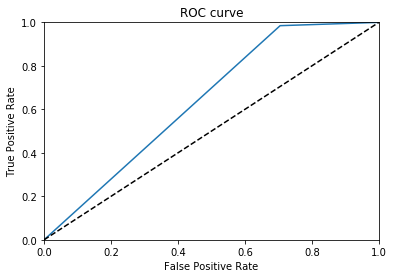

In [26]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()

In [27]:
print ("AUC ROC", metrics.roc_auc_score(y_test_roc, y_pred_roc))

AUC ROC 0.6398582455335233


## XGBClassifier

In [28]:
from xgboost import XGBClassifier
clf = XGBClassifier().fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(metrics.classification_report(y_test, y_pred, target_names=le.classes_[np.unique(y_test)]))

              precision    recall  f1-score   support

      Figure       1.00      1.00      1.00         5
     Heading       0.90      0.87      0.88       253
 Information       0.67      0.44      0.53       169
 Requirement       0.92      0.96      0.94      1446
       Title       0.00      0.00      0.00         7

    accuracy                           0.90      1880
   macro avg       0.70      0.65      0.67      1880
weighted avg       0.89      0.90      0.89      1880



In [29]:
import scipy.stats as st

random_search = {'alpha': list(np.linspace(0.0, 1.0, 11, dtype = float)) + [None],
               'fit_prior': [True, False],
                'norm': [False, True]}

one_to_left = st.beta(10, 1)  
from_zero_positive = st.expon(0, 50)

random_search = {  
    "n_estimators": st.randint(3, 40),
    "max_depth": st.randint(3, 40),
    "learning_rate": st.uniform(0.05, 0.4),
    "colsample_bytree": one_to_left,
    "subsample": one_to_left,
    "gamma": st.uniform(0, 10),
    'reg_alpha': from_zero_positive,
    "min_child_weight": from_zero_positive,
}


clf = XGBClassifier()
model = RandomizedSearchCV(estimator = clf, param_distributions = random_search, n_iter = 80, 
                               cv = 4, verbose= 5, random_state= 101, n_jobs = -1)
model.fit(X_train,y_train)

Fitting 4 folds for each of 80 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   21.5s
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:   25.7s finished


RandomizedSearchCV(cv=4, error_score=nan,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n...
                                        'min_child_weight': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fd640437fd0>,
                                        'n_estim

In [30]:
predictionforest = model.best_estimator_.predict(X_test)
print(metrics.confusion_matrix(y_test,predictionforest), '\n')
print(metrics.classification_report(y_test, predictionforest, target_names=le.classes_[np.unique(y_test)]))
acc3 = metrics.accuracy_score(y_test,predictionforest)

[[   0    0    0    5    0]
 [   0  222    0   31    0]
 [   0    7    0  162    0]
 [   0   42    0 1404    0]
 [   0    6    0    1    0]] 

              precision    recall  f1-score   support

      Figure       0.00      0.00      0.00         5
     Heading       0.80      0.88      0.84       253
 Information       0.00      0.00      0.00       169
 Requirement       0.88      0.97      0.92      1446
       Title       0.00      0.00      0.00         7

    accuracy                           0.86      1880
   macro avg       0.34      0.37      0.35      1880
weighted avg       0.78      0.86      0.82      1880



/Users/marychikunova/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [25]:
from sklearn.model_selection import GridSearchCV

grid_search = {
    "max_depth": list(np.linspace(3, 40, 10, dtype = int)) + [None],
    'n_estimators': list(np.linspace(3, 40, 10, dtype = int)) + [None], 

    'learning_rate': list(np.linspace(0, 0.5, 5, dtype = float)) + [None],
    'gamma': list(np.linspace(0, 1, 10, dtype = float)) + [None], 
    
    #'one_to_lef': = st.beta(10, 1)
    #colsample_bytree": one_to_left,
    #"subsample": one_to_left,
    #'reg_alpha': from_zero_positive,
}

clf = XGBClassifier()
model = GridSearchCV(estimator = clf, param_grid = grid_search, cv = 4, verbose= 5, n_jobs = -1)
model.fit(X_train,y_train)

predictionforest = model.best_estimator_.predict(X_test)
print(metrics.confusion_matrix(y_test,predictionforest))
print(metrics.classification_report(y_test,predictionforest))

Fitting 4 folds for each of 7986 candidates, totalling 31944 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 162 tasks      | elapsed:   36.6s
[Parallel(n_jobs=-1)]: Done 288 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 450 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 648 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 882 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 1152 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 1458 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 1800 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 2178 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done 2592 tasks      | elapsed: 11.6min
[Parallel(n_jobs=-1)]: Done 3042 tasks      | elapsed: 13.6min
[Parallel(n_jobs=-1)]: Done 3528 tasks      | elapsed: 16.7min
[Parallel(n_jobs=-1)]: Done 4050 tasks      | ela

[[   5    0    0    0    0]
 [   0  218    1   32    2]
 [   0    2   55  112    0]
 [   3   21   30 1392    0]
 [   0    6    0    1    0]]
              precision    recall  f1-score   support

           0       0.62      1.00      0.77         5
           1       0.88      0.86      0.87       253
           2       0.64      0.33      0.43       169
           3       0.91      0.96      0.93      1446
           4       0.00      0.00      0.00         7

    accuracy                           0.89      1880
   macro avg       0.61      0.63      0.60      1880
weighted avg       0.87      0.89      0.88      1880



In [31]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

length = len(y_test)

y_test_roc = np.zeros(length)
y_pred_roc = np.zeros(length)

for i in range (length):
    if(y_test[i] == 3): y_test_roc[i] = 1
        
for i in range (length):
    if(y_pred[i] == 3): y_pred_roc[i] = 1
        
fpr, tpr, thresholds = metrics.roc_curve(y_test_roc, y_pred_roc)

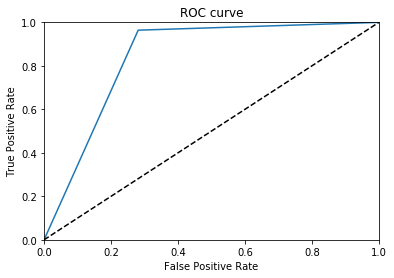

In [32]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()

In [33]:
print ("AUC ROC", metrics.roc_auc_score(y_test_roc, y_pred_roc))

AUC ROC 0.8414663683703973
